Notebook that uses double star observations to determine a CCD's plate scale

In [1]:
import numpy as np
from numpy import pi, r_
import matplotlib.pyplot as plt
from scipy import optimize
from astropy.io import fits
import math
# uncertainties package, from https://pythonhosted.org/uncertainties/
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.

In [2]:
#From http://scipy-cookbook.readthedocs.io/items/FittingData.html
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [25]:
# load reduced images of binary/double star
# pre-January-2018
#directory = '/Volumes/external_hd/binary_march2016/'
#imlist = np.loadtxt(directory+'imlist2',dtype=str)

# post-January-2018 (May 2018)
directory = '/Volumes/external_hd/doublestar_data_may2018/'
imlist = np.loadtxt('/Volumes/external_hd/doublestar_data_may2018/doublestar_may2018',dtype=str)

# post-January-2018 (Feb. 2018)
#directory = '/Users/dahlek/Desktop/binarystar_feb2018/'
#imlist = np.loadtxt('/Users/dahlek/Desktop/binarystar_feb2018/imlist',dtype=str)

NC0000245358.FIT


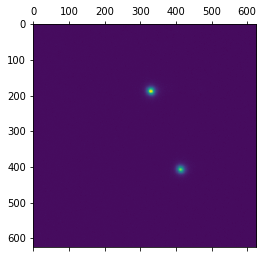

In [18]:
# print an image to see where the stars are
im = fits.open(directory+imlist[3])
print imlist[3]
#im[0].header
plt.matshow(im[0].data)
plt.show()

In [26]:
# user-defined region of the data array that contains the primary and secondary stars

# F47 values
'''y1prim = 230
y2prim = 280
x1prim = 250
x2prim = 300

y1sec = 190
y2sec = 230
x1sec = 300
x2sec = 350'''


# F8300 values
y1prim = 150
y2prim = 300
x1prim = 200
x2prim = 350

y1sec = 400
y2sec = 480
x1sec = 315
x2sec = 415

box_size = 20

distance_with_error = [] # ufloats containing distance and error
distance = []
error = []
wl = []

for i in range(0,len(imlist)):
    im = fits.open(directory+imlist[i])
    
    if im[0].header['rfon'] == 1:
        
        #Primary star
        # Find location of maximum value in user-defined region
        ind_prim = np.unravel_index(np.argmax(im[0].data[y1prim:y2prim,x1prim:x2prim], axis=None), im[0].data[y1prim:y2prim,x1prim:x2prim].shape)
        
        #Define a region to fit a Gaussian to
        newarray_prim = im[0].data[(y1prim+ind_prim[0]-box_size):(y1prim+ind_prim[0]+box_size),(x1prim+ind_prim[1]-box_size):(x1prim+ind_prim[1]+box_size)]
        #Fit a Gaussian
        prim_y,prim_x = fitgaussian(newarray_prim)[1],fitgaussian(newarray_prim)[2]
        prim_y_error, prim_x_error = fitgaussian(newarray_prim)[3],fitgaussian(newarray_prim)[4]
        #Round them to ints
        x_prim_final = int(round((x1prim+ind_prim[1]-box_size)+prim_x))
        y_prim_final = int(round((y1prim+ind_prim[0]-box_size)+prim_y))
        
        #print x_prim_final,y_prim_final
        
        
        #Secondary star
        # Find location of maximum value in user-defined region
        ind_sec = np.unravel_index(np.argmax(im[0].data[y1sec:y2sec,x1sec:x2sec], axis=None), im[0].data[y1sec:y2sec,x1sec:x2sec].shape)
        
        #Define a region to fit a Gaussian to
        newarray_sec = im[0].data[(y1sec+ind_sec[0]-box_size):(y1sec+ind_sec[0]+box_size),(x1sec+ind_sec[1]-box_size):(x1sec+ind_sec[1]+box_size)]
        #Fit a Gaussian
        sec_y,sec_x = fitgaussian(newarray_sec)[1],fitgaussian(newarray_sec)[2]
        sec_y_error,sec_x_error = fitgaussian(newarray_sec)[3],fitgaussian(newarray_sec)[4]
        #Round them to ints
        x_sec_final = int(round((x1sec+ind_sec[1]-box_size)+sec_x))
        y_sec_final = int(round((y1sec+ind_sec[0]-box_size)+sec_y))
                
        #print x_sec_final,y_sec_final
        
        # make their positions ufloats
        x_prim_final_with_error = ufloat(x_prim_final,prim_x_error)
        x_sec_final_with_error = ufloat(x_sec_final,sec_x_error)
        y_prim_final_with_error = ufloat(y_prim_final,prim_y_error)
        y_sec_final_with_error = ufloat(y_sec_final,sec_y_error)
                
        distance_with_error.append(((x_prim_final_with_error-x_sec_final_with_error)**2+(y_prim_final_with_error-y_sec_final_with_error)**2)**0.5)
        
        error.append( (((x_prim_final_with_error-x_sec_final_with_error)**2+(y_prim_final_with_error-y_sec_final_with_error)**2)**0.5).std_dev  )
        
        distance.append( (((x_prim_final_with_error-x_sec_final_with_error)**2+(y_prim_final_with_error-y_sec_final_with_error)**2)**0.5).nominal_value )
        
        wl.append(im[0].header['lambda'])
        

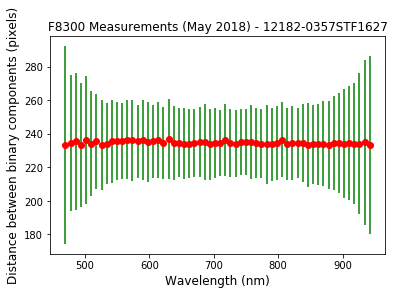

In [27]:
plt.errorbar(wl,distance,fmt='o',color='red',ecolor='g',yerr=np.array(error))
plt.title('F8300 Measurements (May 2018) - 12182-0357STF1627')
plt.ylabel('Distance between binary components (pixels)',size=12)
plt.xlabel('Wavelength (nm)',size=12)
plt.show()

In [28]:
plt.errorbar(wl,distance,fmt='o',color='red',ecolor='g',yerr=np.array(error))
plt.title('F47 Measurements (March 2016) - 10200+1950STF1424AB')
plt.ylabel('Distance between binary components (pixels)',size=12)
plt.xlabel('Wavelength (nm)',size=12)
plt.show()

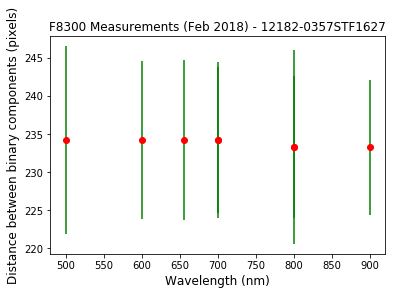

In [21]:
plt.errorbar(wl,distance,fmt='o',color='red',ecolor='g',yerr=np.array(error))
plt.title('F8300 Measurements (Feb 2018) - 12182-0357STF1627')
plt.ylabel('Distance between binary components (pixels)',size=12)
plt.xlabel('Wavelength (nm)',size=12)
plt.show()

In [7]:
%matplotlib qt5

In [25]:
# Load the distance between these stars in "; find these values on Simbad
# Stars used for NAIC: 
# pre-2018 (observed in March 2016): 4.73" (data can be found in /Volumes/PAL/emmas_external_hd/binary_march2016/)
star_distance = ufloat(4.73,4.73*0.05) # assuming 5% error in angular sep measurements

In [26]:
# Find the average plate scale and error 
star_distance/np.mean(distance_with_error) # in "/pix

0.10393581111644473+/-0.005847473311341126

In [31]:
# post-2018 (observed in May 2018): 19.9" (data can be found in /Volumes/PAL/emmas_external_hd/doublestar_data_may2018/)
#star_distance = ufloat(19.9,19.9*0.05) # old assumption; assuming 5% error in angular sep measurements

In [8]:
# Find the average plate scale and error 
star_distance/np.mean(distance_with_error) # in "/pix

0.0847900011797713+/-0.004432559233932486

In [23]:
# post-2018 (observed in Feb 2018):
star_distance/np.mean(distance_with_error) # in "/pix

0.0850972085838623+/-0.004465810231350789

In [24]:
# feb 2018 star seperation in pixels
print np.mean(distance_with_error)

234+/-4


In [28]:
# may 2018 star seperation in pixels
print np.mean(distance_with_error)

235+/-4


In [3]:
# Final post-2018 camera measurements:
distance_with_error = ufloat(235,4)
star_distance = ufloat(20.0479,0.03969) # from binary_measurements_2018.ipynb
star_distance/np.mean(distance_with_error)

0.08531021276595745+/-0.001461877808729359